In [1]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import cv2

# Load simulation results

In [2]:
# Change the date time to the date time of the pickle file you want to load
date = '231102'
time = '1656'
date_time = date + '_' + time
path = './data/' + date + '/'

data_fanatics = path + date_time + '_fanatics.pkl'
data_fanatics = pd.read_pickle(data_fanatics)

data_no_fanatics = path + date_time + '_no_fanatics.pkl'
data_no_fanatics = pd.read_pickle(data_no_fanatics)

### Last network

In [3]:
# Add the last network and belief to the data_fanatics DataFrame
data_fanatics['last_network'] = data_fanatics['network_array'].apply(lambda x: x[-1])
data_fanatics['last_belief'] = data_fanatics['belief_array'].apply(lambda x: x[-1])

# Add the last network and belief to the data_non_fanatics DataFrame
data_no_fanatics['last_network'] = data_no_fanatics['network_array'].apply(lambda x: x[-1])
data_no_fanatics['last_belief'] = data_no_fanatics['belief_array'].apply(lambda x: x[-1])

### In-degree

In [4]:
def get_indegree(network):
    G = nx.from_numpy_array(network, create_using=nx.DiGraph)
    indegree = np.array([G.in_degree(n) for n in G.nodes()])
    return indegree

In [5]:
data_fanatics['last_indegree'] = data_fanatics['last_network'].apply(lambda x: get_indegree(x))
data_no_fanatics['last_indegree'] = data_no_fanatics['last_network'].apply(lambda x: get_indegree(x))

### Split dataset

3 datasets
- `fanatics_scheme == 'max'`: all fanatics have a belief of 1.
- `fanatics_scheme == 'min-max'`: half of the fanatics have a belief of 0, the other half have a belief of 1.
- `fanatics_scheme == 'mean'`: all fanatics have a belief of 0.5.

In [6]:
def get_fanatics(data_fanatics: np.ndarray, data_no_fanatics: np.ndarray, scheme: str, switching_prob: float):
    """
    Concatenate the results of the simulations with fanatics and the results of the simulations without fanatics for a fanatic scheme

    Params:
        data_fanatics (np.ndarray): Fanatics datasets
        data_no_fanatics (np.ndarray): Non-fanatics dataset
        fanatics_scheme (str): Fanatics scheme (max, min-max, mean)
    """
    data = data_fanatics[data_fanatics['fanatics_scheme'] == scheme]
    data = pd.concat([data_no_fanatics, data])
    data = data[data['switching_prob'] == switching_prob]
    data['fanatics_scheme'] = scheme

    return data

In [7]:
fanatics_max_low = get_fanatics(data_fanatics, data_no_fanatics, 'max', 0.5)
fanatics_max_high = get_fanatics(data_fanatics, data_no_fanatics, 'max', 1)
fanatics_min_max_low = get_fanatics(data_fanatics, data_no_fanatics, 'min-max', 0.5)
fanatics_min_max_high = get_fanatics(data_fanatics, data_no_fanatics, 'min-max', 1)
fanatics_mean_low = get_fanatics(data_fanatics, data_no_fanatics, 'mean', 0.5)
fanatics_mean_high = get_fanatics(data_fanatics, data_no_fanatics, 'mean', 1)

print(fanatics_max_low.shape, fanatics_min_max_high.shape, fanatics_mean_high.shape)

(25, 31) (25, 31) (25, 31)


# Analyze results


## Visuals

### Network and Belief Coevolution

In [8]:
def visualize_beliefs_helper(beliefs: np.ndarray, ax: plt.Axes) -> plt.figure:
    """
    Visualize clusters of beliefs in different periods of the network. 
    This is the core function behind Graeme's Figure 1+4.

    People in the same subnetwork tend to have the same beliefs

    Params:
        beliefs (np.ndarray): The belief of each person in the network
        conv (int): the current period of the simulation. If 0, don't show. If -1, "converged".
        ax (plt.Axes): the figure's axes instance

    Returns:
        fig: The figure of the belief of people (in Graeme's paper)
    """
    # Sort belief and plot
    sorted_b = np.sort(beliefs)[::-1]

    # Plot figure
    ax.set_box_aspect(1/3)
    fig = ax.barh(list(range(len(sorted_b))), sorted_b, height=1)
    ax.xaxis.set_ticks(np.arange(0, 1.1, 0.2))
    ax.set_xlim(0, 1)
    ax.set_ylim(-0.5, len(sorted_b))
    ax.yaxis.set_visible(False)
    return fig

def visualize_network_helper(beliefs: np.ndarray, networks: np.ndarray, conv: int, ax: plt.Axes) -> plt.figure:
    """
    Visualize segments/clusters of the network.
    This is the core function behind Graeme's Figure 4.

    Params:
        beliefs (np.ndarray): The belief of each person in the network
        networks (np.ndarray): The network of people
        conv (int): The current period of the simulation
        ax (plt.Axes): the figure's axes instance

    Returns:
        fig: The figure of the networks of people
    """
    # Sort people according to beliefs
    members = np.argsort(np.argsort(beliefs))
    # Convert matrix to dictionary
    network = {i: np.where(networks[i] == 1) for i in range(networks.shape[0])}
    # Reindex people according to sorted beliefs
    sort_network = {members[i]: [members[fr]
                                 for fr in network[i]] for i in range(len(members))}

    # Create array for scatter plot
    sort_y = np.array([[y, y, y, y]
                      for y in list(sort_network.keys())]).flatten()
    sort_x = np.array(list(sort_network.values())).flatten()

    # Plot figure
    ax.set(xlim=(0, np.max(sort_x)), ylim=(np.max(sort_y), 0))
    ax.set_box_aspect(1)
    fig = ax.scatter(sort_x, sort_y, 0.2)
    conv = str(conv) if conv != -1 else "converged"
    ax.set_xlabel(f"t = {conv}")
    ax.tick_params(labelbottom='off')
    ax.yaxis.set_visible(False)

    return fig

def visualize_coevolution(data: pd.DataFrame, beta: float, export=False) -> plt.figure:
    """
    Graeme's Figure 4: Coevolution of Beliefs and Networks

    Params:
        results (pd.DataFrame): The results of the simulations
        fanatics_scheme (str): Fanatics scheme (max, min-max, mean)
        beta (float): Social dissonance value
        export (bool): Export this figure if `true`
        name (str): the OUTPUT_NAME of this program

    Returns:
        fig: The figure of networks & beliefs coevolution (in Graeme's paper)
    """
    FANATICS_COUNT = data['num_fanatics'].unique().size
    fig, axs = plt.subplots(nrows=4, ncols=FANATICS_COUNT*2, gridspec_kw={'width_ratios': [1, 3] * FANATICS_COUNT}, figsize=(FANATICS_COUNT * 4, 8))

    # Loop through different values of num_fanatics
    for i, num_fanatics in enumerate(data['num_fanatics'].unique()):
        df = data[(data['num_fanatics'] == num_fanatics)
                     & (data['beta'] == beta)]

        # Visualize belief at 4 different time steps
        timesteps = [1, 5, 20, -1]

        for j, time in enumerate(timesteps):
            visualize_network_helper(df['belief_array'].iloc[0][j],
                                     df['network_array'].iloc[0][j],
                                     time, axs[j, (i % FANATICS_COUNT)*2])
            # df['belief_array] is a list of np.ndarray of beliefs at time t
            visualize_beliefs_helper(df['belief_array'].iloc[0][j],
                                     axs[j, (i % FANATICS_COUNT)*2+1])

        axs[i // FANATICS_COUNT, (i % FANATICS_COUNT)*2].set_title(f"Fanatics = {num_fanatics}")
    
    fanatics_scheme = data["fanatics_scheme"].sample().str.cat(sep='')
    switching_prob = data["switching_prob"].sample().values[0]
    scheme = ''
    if fanatics_scheme == 'max':
        scheme = 'All fanatics hold the highest beliefs'
    elif fanatics_scheme == 'min-max':
        scheme = 'Half of the fanatics hold the highest beliefs, the other half hold the lowest beliefs'
    elif fanatics_scheme == 'mean':
        scheme = 'All fanatics hold the beliefs in the middle'
        
    fig.suptitle(f"Coevolution of beliefs and networks \n ({scheme}) \n (beta = {round(beta, 2)}, switching_prob = {switching_prob})")
    plt.tight_layout()

    # Save figure
    if export:
        try:
            os.mkdir(f'./plots/{date}')
        except FileExistsError:
            pass
        plt.savefig(f'./plots/{date}/{date_time}_coev_{fanatics_scheme}_{switching_prob}_{round(beta, 2)}.png', facecolor='white')
    plt.close()
    return fig

In [9]:
beta = fanatics_max_low['beta'].unique()
for b in beta:
    visualize_coevolution(data=fanatics_max_low, beta=b, export=True)

beta = fanatics_max_high['beta'].unique()
for b in beta:
    visualize_coevolution(data=fanatics_max_high, beta=b, export=True)

beta = fanatics_min_max_low['beta'].unique()
for b in beta:
    visualize_coevolution(data=fanatics_min_max_low, beta=b, export=True)

beta = fanatics_min_max_high['beta'].unique()
for b in beta:
    visualize_coevolution(data=fanatics_min_max_high, beta=b, export=True)

beta = fanatics_mean_low['beta'].unique()
for b in beta:
    visualize_coevolution(data=fanatics_mean_low, beta=b, export=True)

beta = fanatics_mean_high['beta'].unique()
for b in beta:
    visualize_coevolution(data=fanatics_mean_high, beta=b, export=True)

### Clustering coefficient

In [10]:
def visualize_clustering_coeff(data_fanatics: pd.DataFrame, data_no_fanatics: pd.DataFrame,
                               fanatics_scheme: list, beta: list, num_fanatics: int, switching_prob: float, export=False) -> plt.figure:
    # Line plot
    fig = plt.figure(figsize=(10,6))

    # Plot individual line for each param set
    for (fanatic_value, beta_value) in itertools.product(fanatics_scheme, beta):
        data = get_fanatics(data_fanatics, data_no_fanatics, fanatic_value, switching_prob = switching_prob)
        net_arr = data[(data['beta'] == beta_value) & (data['num_fanatics'] == num_fanatics)]["network_array"].reset_index(drop=True)[0]
        clustering_coeffs = np.zeros(shape=len(net_arr))

        # Calculate clustering coef
        for i in range(len(net_arr)):
            G = nx.from_numpy_array(net_arr[i])
            clustering_coeffs[i] = nx.average_clustering(G)
        
        plt.plot(np.arange(0, len(clustering_coeffs)), clustering_coeffs, label=f"{fanatic_value} {beta_value} {switching_prob}")
        
    # Customization
    plt.legend(loc="upper left")
    plt.title(f"Clustering coefficient of {num_fanatics} {fanatics_scheme} fanatics, beta {beta}, and switching prob {switching_prob}")
    plt.ylim([0, 0.45])

    # Export
    if export:
        plt.savefig(f"./plots/{date}/{date_time}_clustering_coeff_{num_fanatics}_{fanatics_scheme}_{switching_prob}_{beta}.png")

    return fig

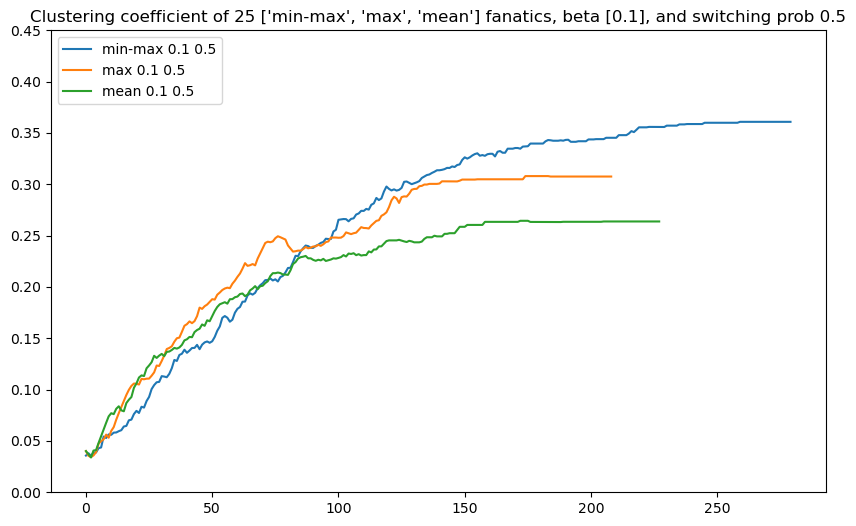

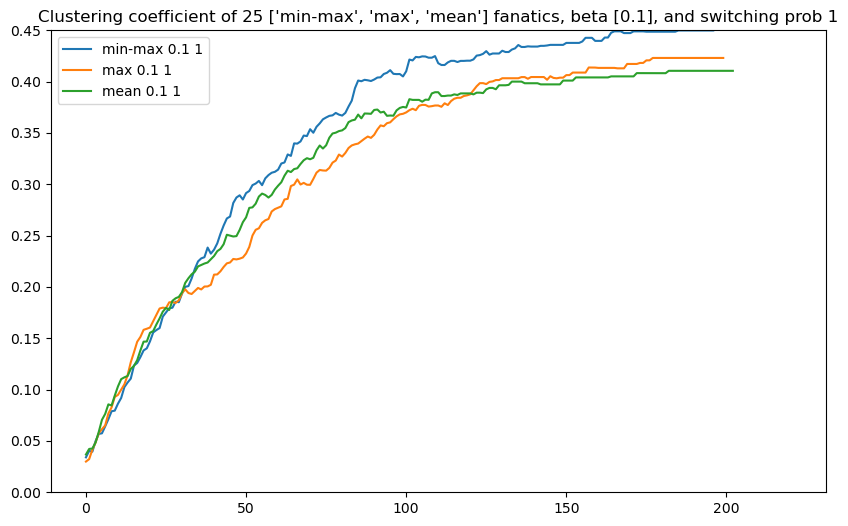

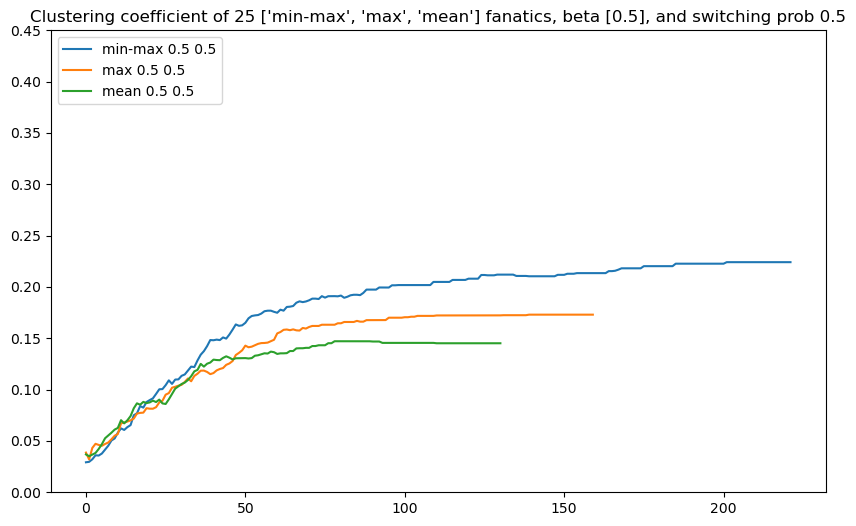

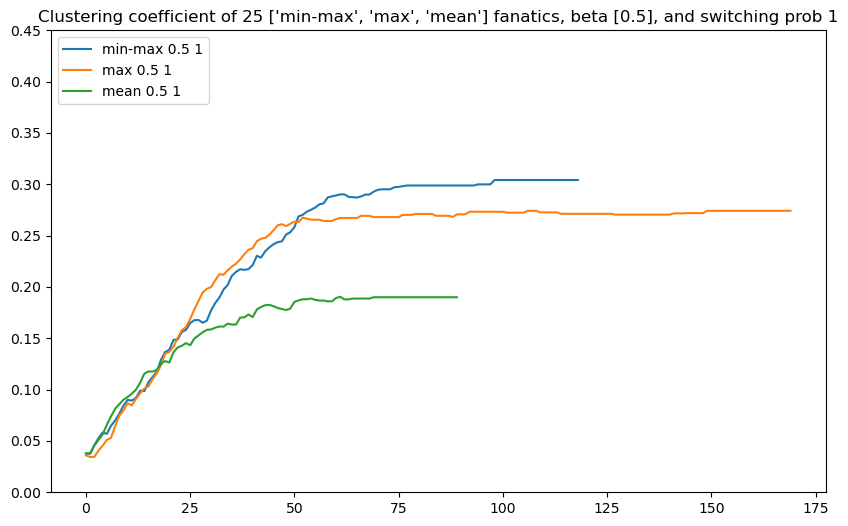

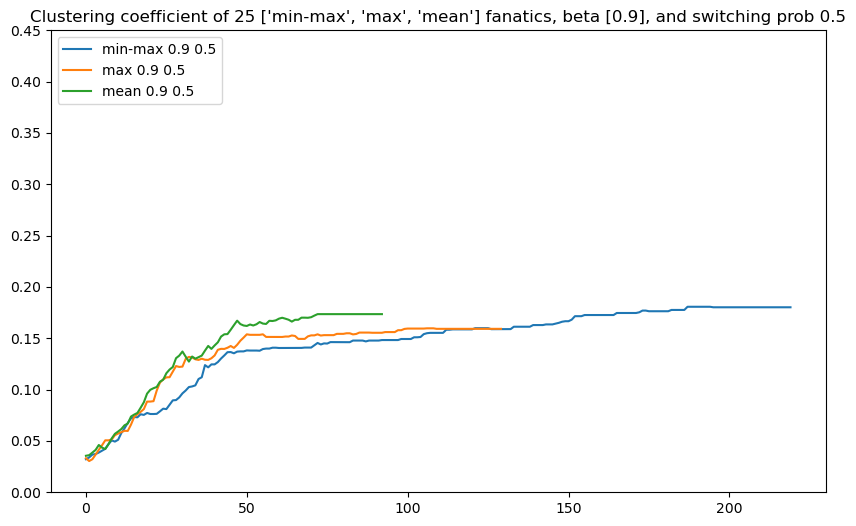

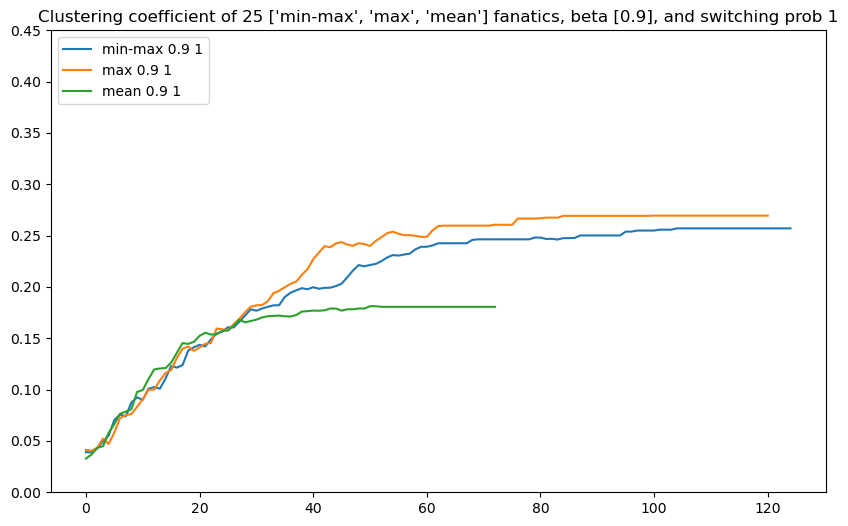

In [11]:
_ = visualize_clustering_coeff(data_fanatics, data_no_fanatics, ["min-max", "max", "mean"], [0.1], num_fanatics=25, switching_prob=0.5, export=True)
_ = visualize_clustering_coeff(data_fanatics, data_no_fanatics, ["min-max", "max", "mean"], [0.1], num_fanatics=25, switching_prob=1, export=True)
_ = visualize_clustering_coeff(data_fanatics, data_no_fanatics, ["min-max", "max", "mean"], [0.5], num_fanatics=25, switching_prob=0.5, export=True)
_ = visualize_clustering_coeff(data_fanatics, data_no_fanatics, ["min-max", "max", "mean"], [0.5], num_fanatics=25, switching_prob=1, export=True)
_ = visualize_clustering_coeff(data_fanatics, data_no_fanatics, ["min-max", "max", "mean"], [0.9], num_fanatics=25, switching_prob=0.5, export=True)
_ = visualize_clustering_coeff(data_fanatics, data_no_fanatics, ["min-max", "max", "mean"], [0.9], num_fanatics=25, switching_prob=1, export=True)

### In-degree

In [12]:
def visualize_indegree(data: pd.DataFrame, export=False):
    """Visualize the distribution of in-degrees."""
    scheme = ''
    fanatics_scheme = data["fanatics_scheme"].sample().str.cat(sep='')
    if fanatics_scheme == 'max':
        scheme = "all fanatics' beliefs=1"
    elif fanatics_scheme == 'min-max':
        scheme = "half of the fanatics' beliefs=1, the other half=0"
    elif fanatics_scheme == 'mean':
        scheme = "all fanatics' beliefs=0.5"

    temp = data.explode('last_indegree')
    palette = sns.color_palette("hls", 10)
    g_indegree = sns.displot(data=temp, x='last_indegree', hue='beta', col='num_fanatics', col_wrap=4, palette=palette, multiple='stack', legend=False, stat='probability')
    g_indegree.set_axis_labels('In-degree', 'Count')
    g_indegree.set_titles('Number of fanatics: {col_name}')
    g_indegree.fig.suptitle(f'Distribution of in-degrees ({scheme})', y=1.05)
    plt.legend(title='beta', labels=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    plt.show(g_indegree)

    # Export
    if export:
        g_indegree.savefig(f'./plots/{date}/{date_time}_indegree_{fanatics_scheme}.png')

/var/folders/kt/4tkq29qs5dxcnk4277k_s7780000gn/T/ipykernel_61106/1962489310.py:14: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  g_indegree = sns.displot(data=temp, x='last_indegree', hue='beta', col='num_fanatics', col_wrap=4, palette=palette, multiple='stack', legend=False, stat='probability')
/Users/quannz/miniconda3/envs/research001/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


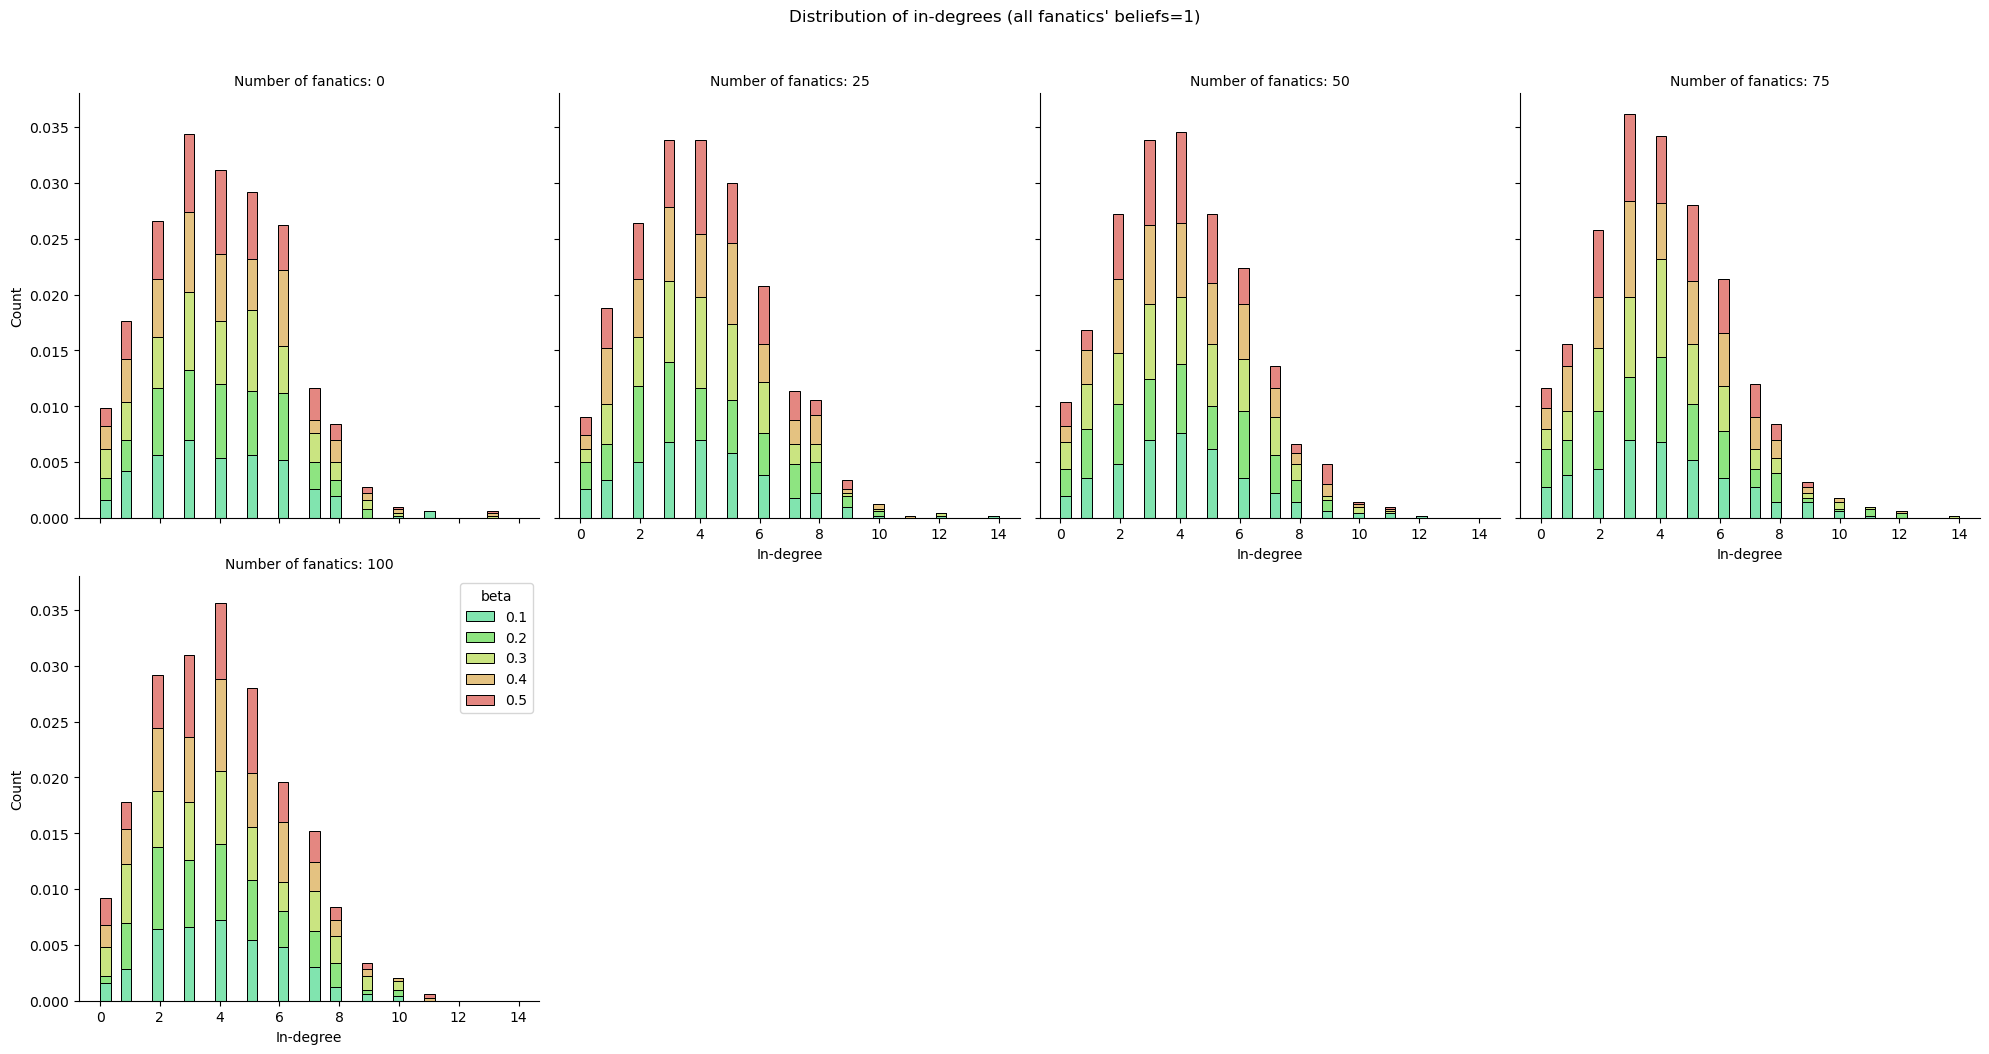

/var/folders/kt/4tkq29qs5dxcnk4277k_s7780000gn/T/ipykernel_61106/1962489310.py:14: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  g_indegree = sns.displot(data=temp, x='last_indegree', hue='beta', col='num_fanatics', col_wrap=4, palette=palette, multiple='stack', legend=False, stat='probability')
/Users/quannz/miniconda3/envs/research001/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


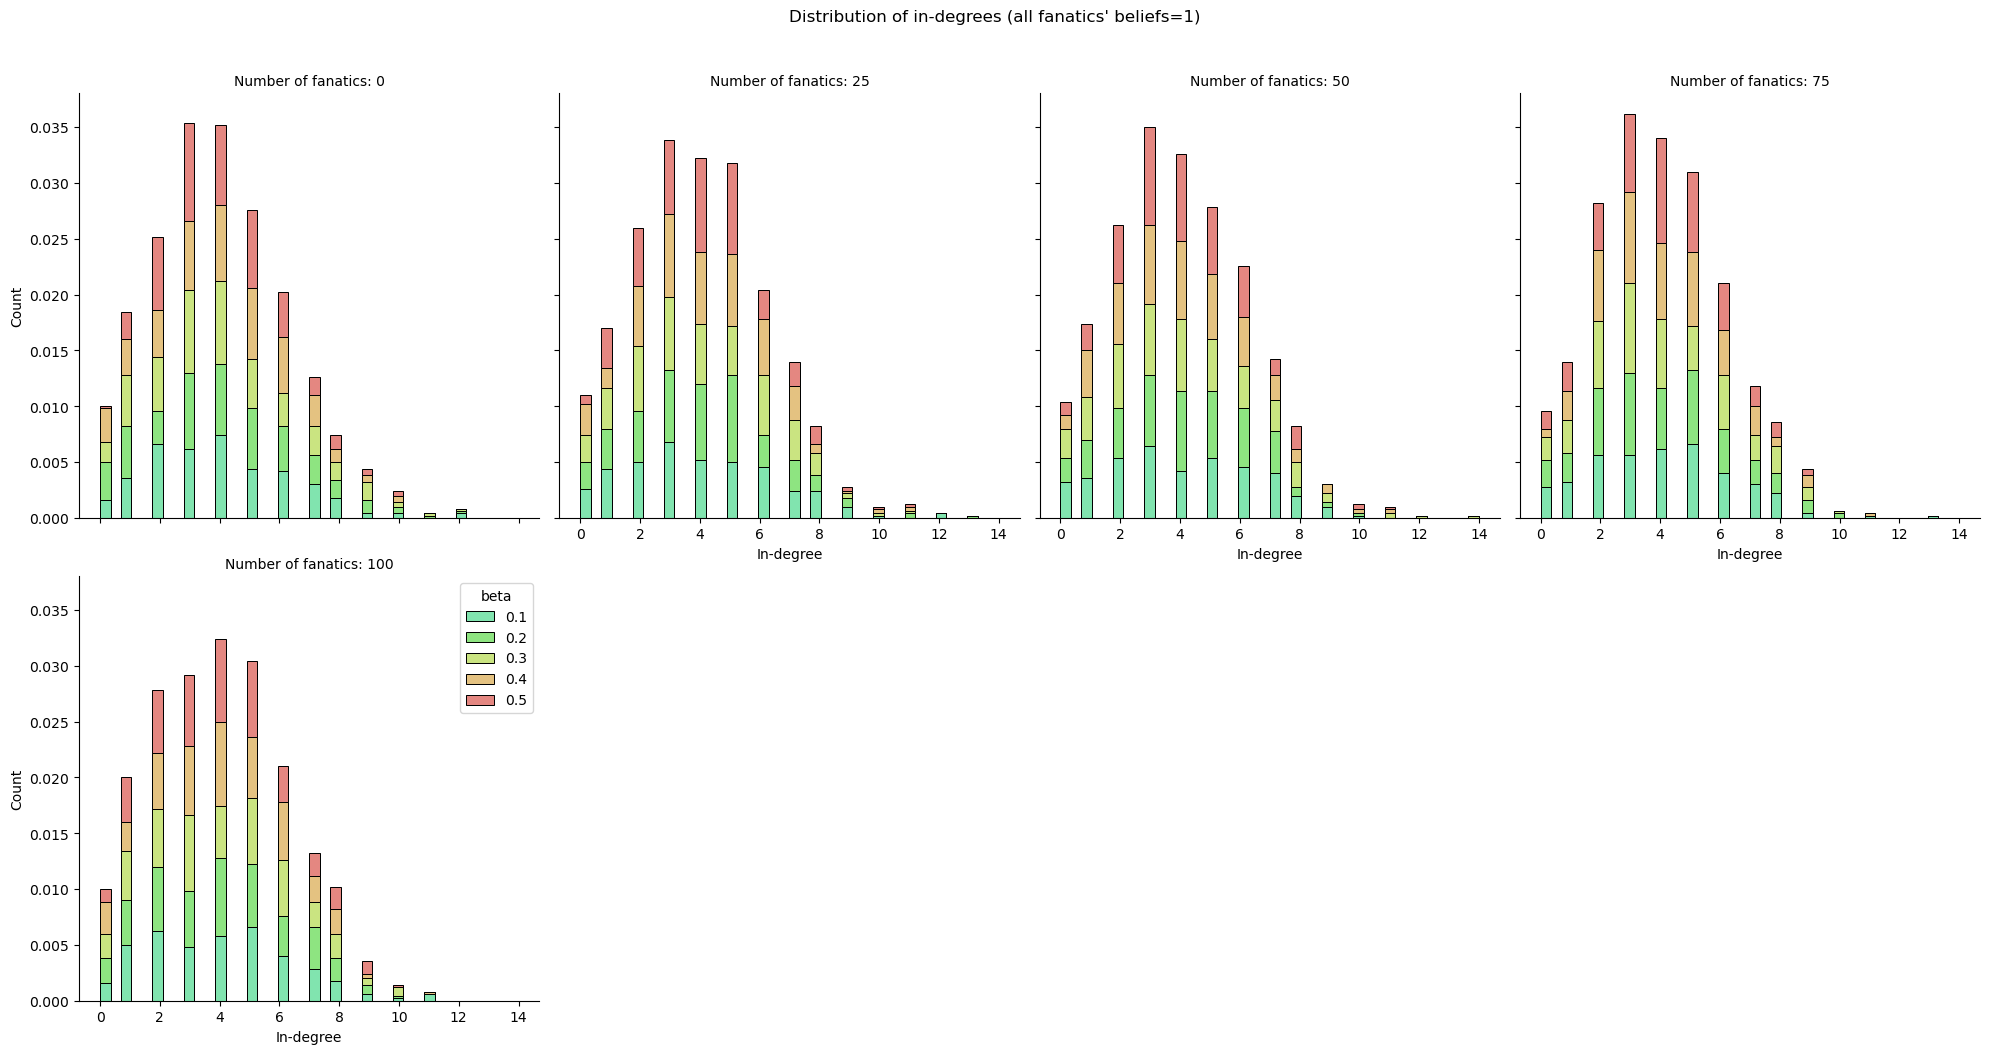

/var/folders/kt/4tkq29qs5dxcnk4277k_s7780000gn/T/ipykernel_61106/1962489310.py:14: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  g_indegree = sns.displot(data=temp, x='last_indegree', hue='beta', col='num_fanatics', col_wrap=4, palette=palette, multiple='stack', legend=False, stat='probability')
/Users/quannz/miniconda3/envs/research001/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


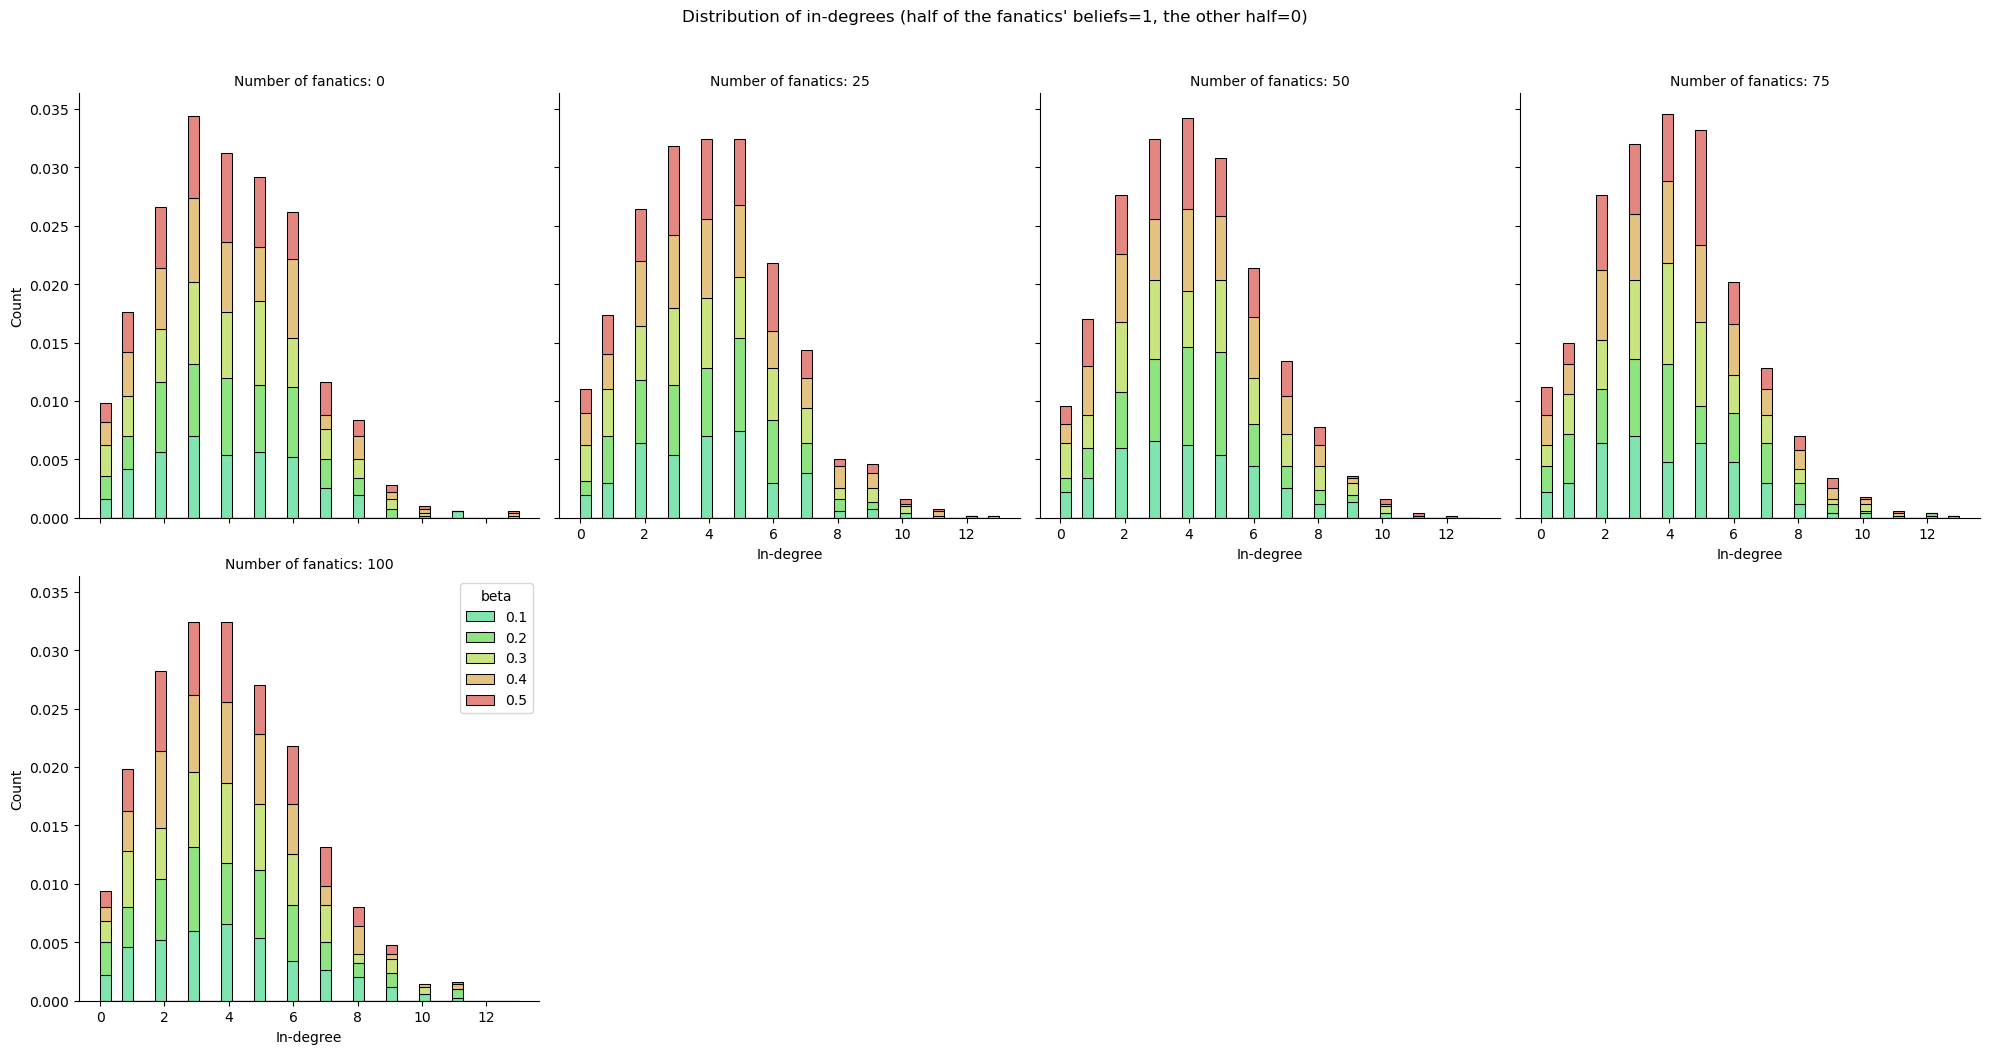

/var/folders/kt/4tkq29qs5dxcnk4277k_s7780000gn/T/ipykernel_61106/1962489310.py:14: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  g_indegree = sns.displot(data=temp, x='last_indegree', hue='beta', col='num_fanatics', col_wrap=4, palette=palette, multiple='stack', legend=False, stat='probability')
/Users/quannz/miniconda3/envs/research001/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


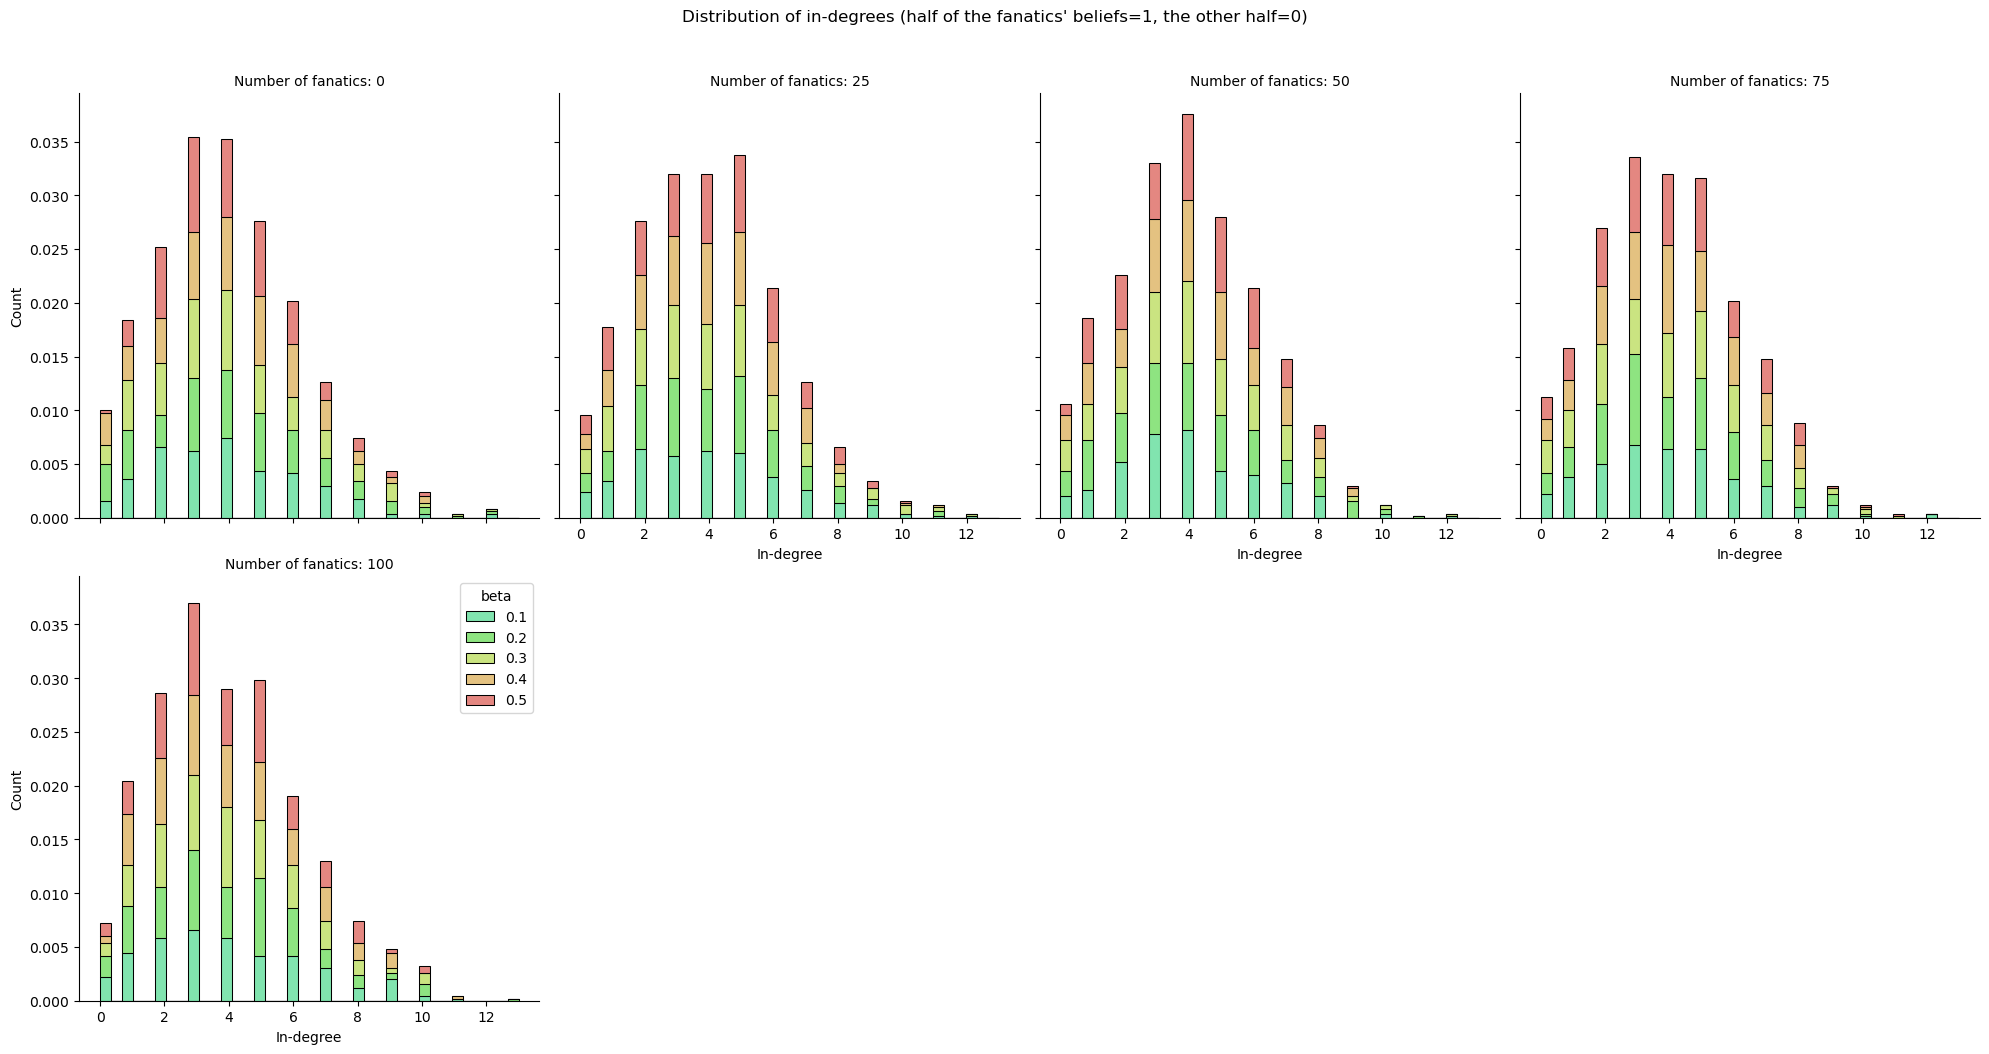

/var/folders/kt/4tkq29qs5dxcnk4277k_s7780000gn/T/ipykernel_61106/1962489310.py:14: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  g_indegree = sns.displot(data=temp, x='last_indegree', hue='beta', col='num_fanatics', col_wrap=4, palette=palette, multiple='stack', legend=False, stat='probability')
/Users/quannz/miniconda3/envs/research001/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


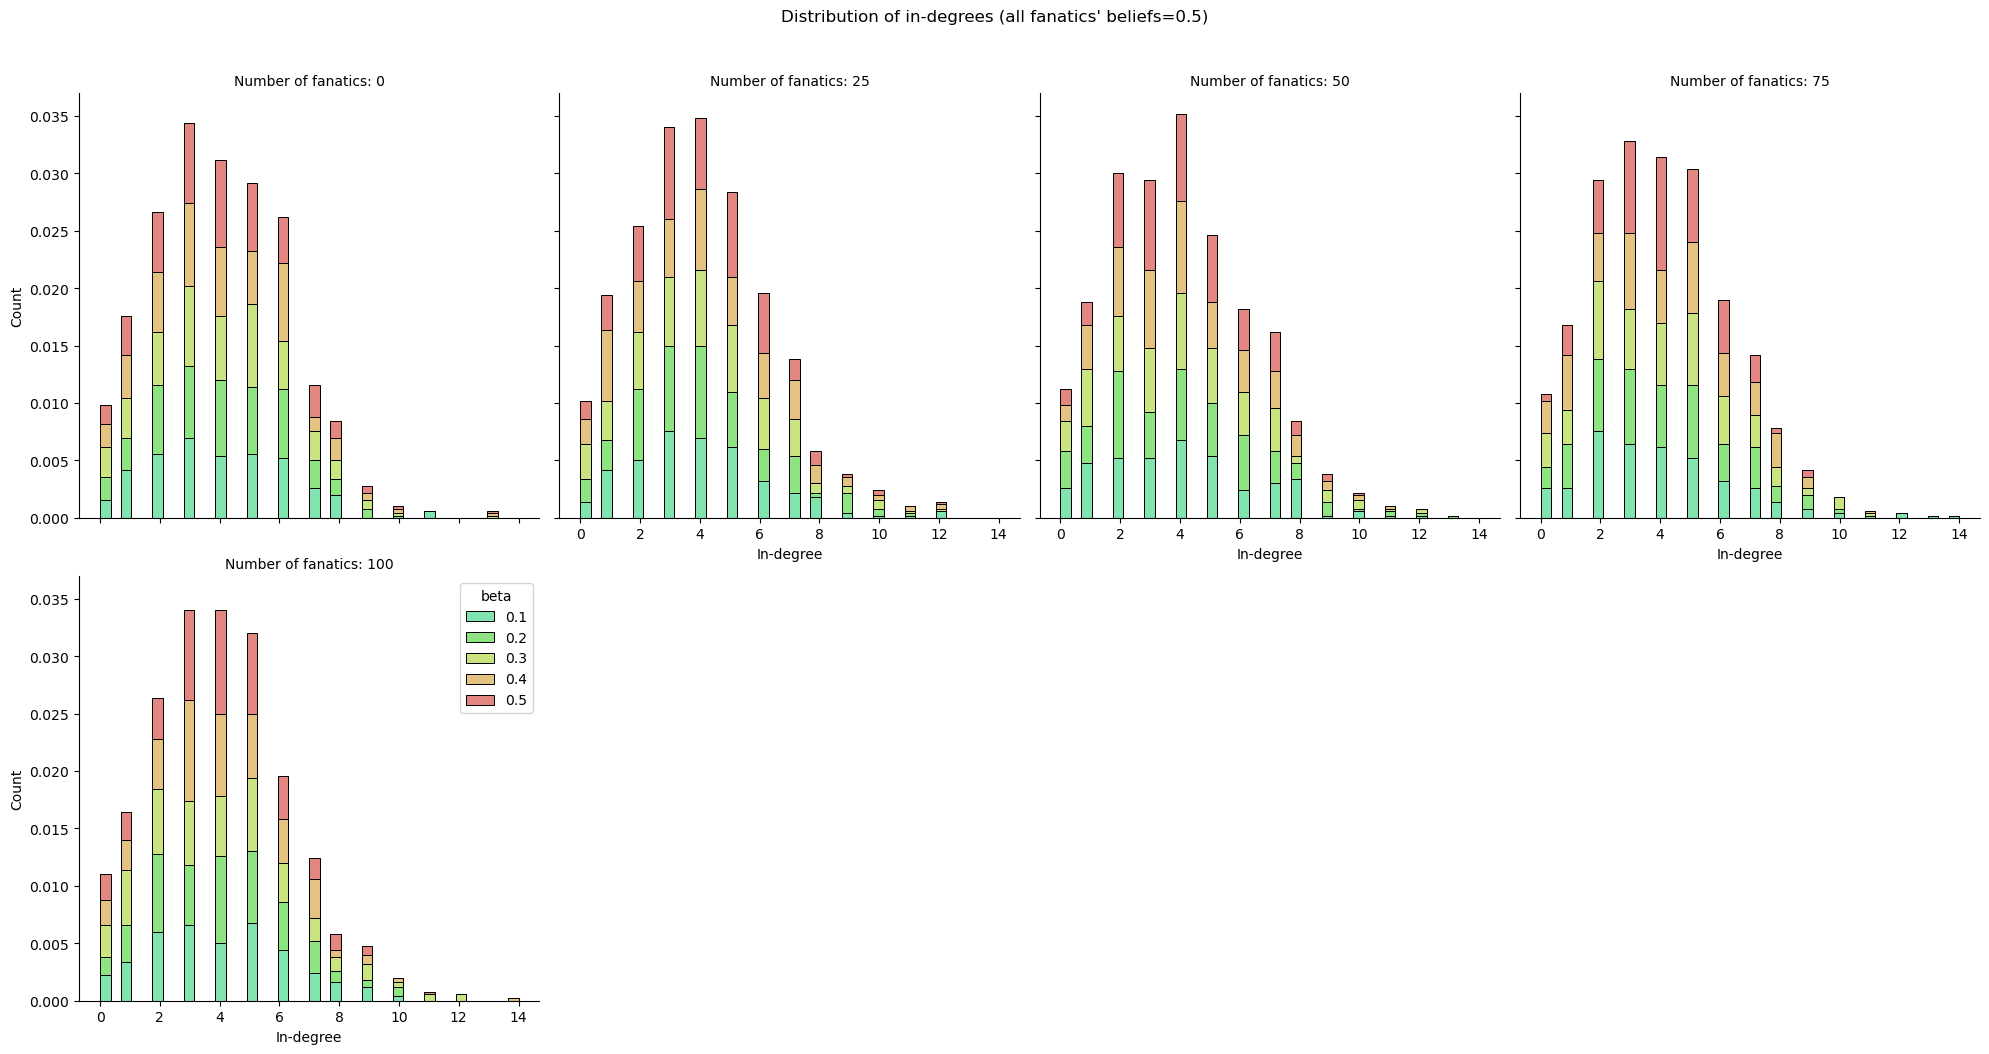

/var/folders/kt/4tkq29qs5dxcnk4277k_s7780000gn/T/ipykernel_61106/1962489310.py:14: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  g_indegree = sns.displot(data=temp, x='last_indegree', hue='beta', col='num_fanatics', col_wrap=4, palette=palette, multiple='stack', legend=False, stat='probability')
/Users/quannz/miniconda3/envs/research001/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


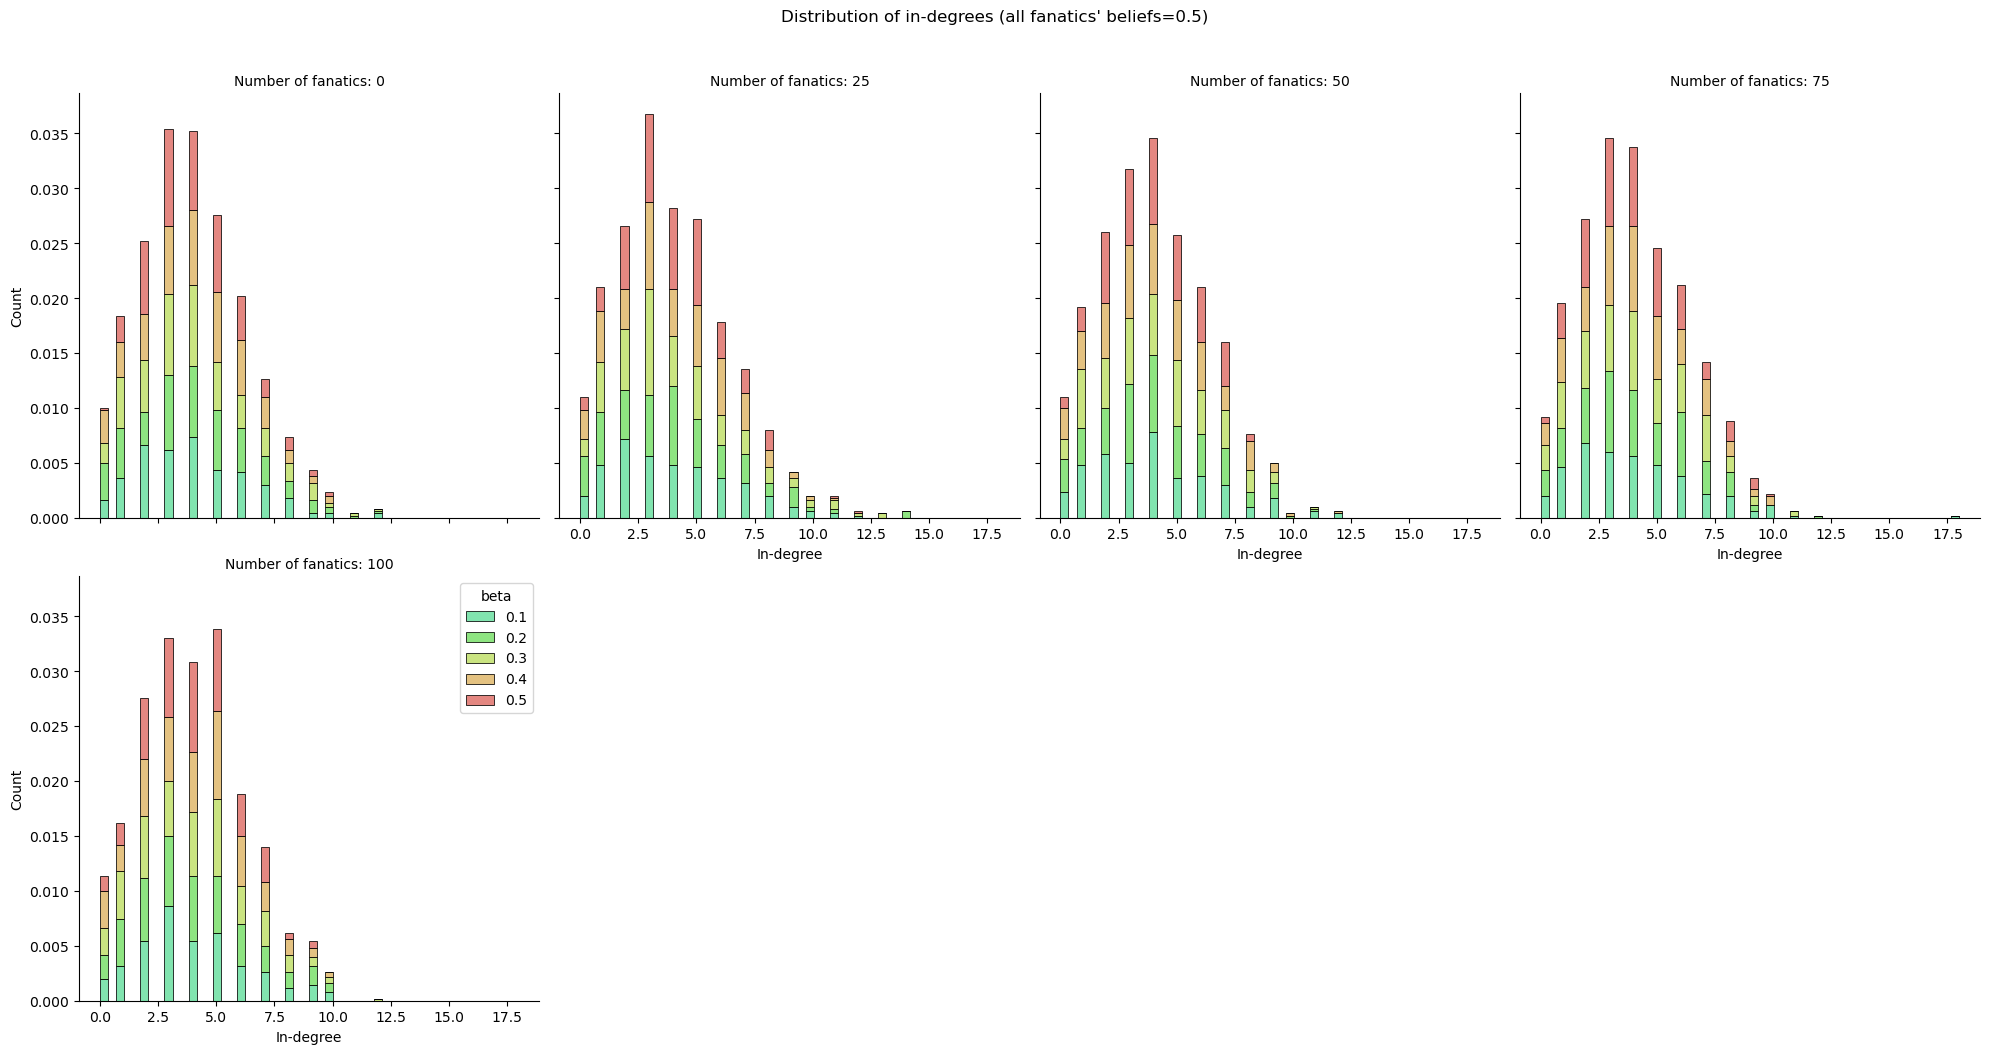

In [13]:
visualize_indegree(fanatics_max_low, export=True)
visualize_indegree(fanatics_max_high, export=True)
visualize_indegree(fanatics_min_max_low, export=True)
visualize_indegree(fanatics_min_max_high, export=True)
visualize_indegree(fanatics_mean_low, export=True)
visualize_indegree(fanatics_mean_high, export=True)

### Metrics

In [18]:
def line_plot(data, metrics, export=False) -> plt.figure:
    """
    Create a line plot of the metric over the beta values.
    """
    fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(20, 10))

    for i, metric in enumerate(metrics):
        g = sns.lineplot(data=data, x='beta', y=metric, hue='num_fanatics', palette='viridis', ax=axs[i//4][i%4])
        if metric in ['MEAN', 'STDEV', 'BIAS', 'ENLITE', 'CON', 'CLUSTERING_COEFFICIENT']:
            g.set_ylim(0, 1)
        if metric in ['MEDIAN_INDEGREE', 'MODE_INDEGREE']:
            g.set_ylim(0, 10)
        if metric in ['MAX_INDEGREE']:
            g.set_ylim(0, 17)
        axs[i//4][i%4].set_title(f'{metric} vs. beta')
        sns.move_legend(g, "upper right", title='# fanatics')

    # Customization
    plt.tight_layout()
    fanatics_scheme = data["fanatics_scheme"].sample().str.cat(sep='')
    if fanatics_scheme == 'max':
        fig.suptitle(f'All fanatics hold the highest beliefs', fontsize=20)
    elif fanatics_scheme == 'min_max':
        fig.suptitle(f'Half of the fanatics hold the highest beliefs, the other half hold the lowest beliefs', fontsize=20)
    elif fanatics_scheme == 'mean':
        fig.suptitle(f'All fanatics hold the mean beliefs', fontsize=16)
    
    # Export
    if export:
        plt.savefig(f'plots/{date}/{date_time}_metrics_{fanatics_scheme}.png')

    plt.show()

    return fig

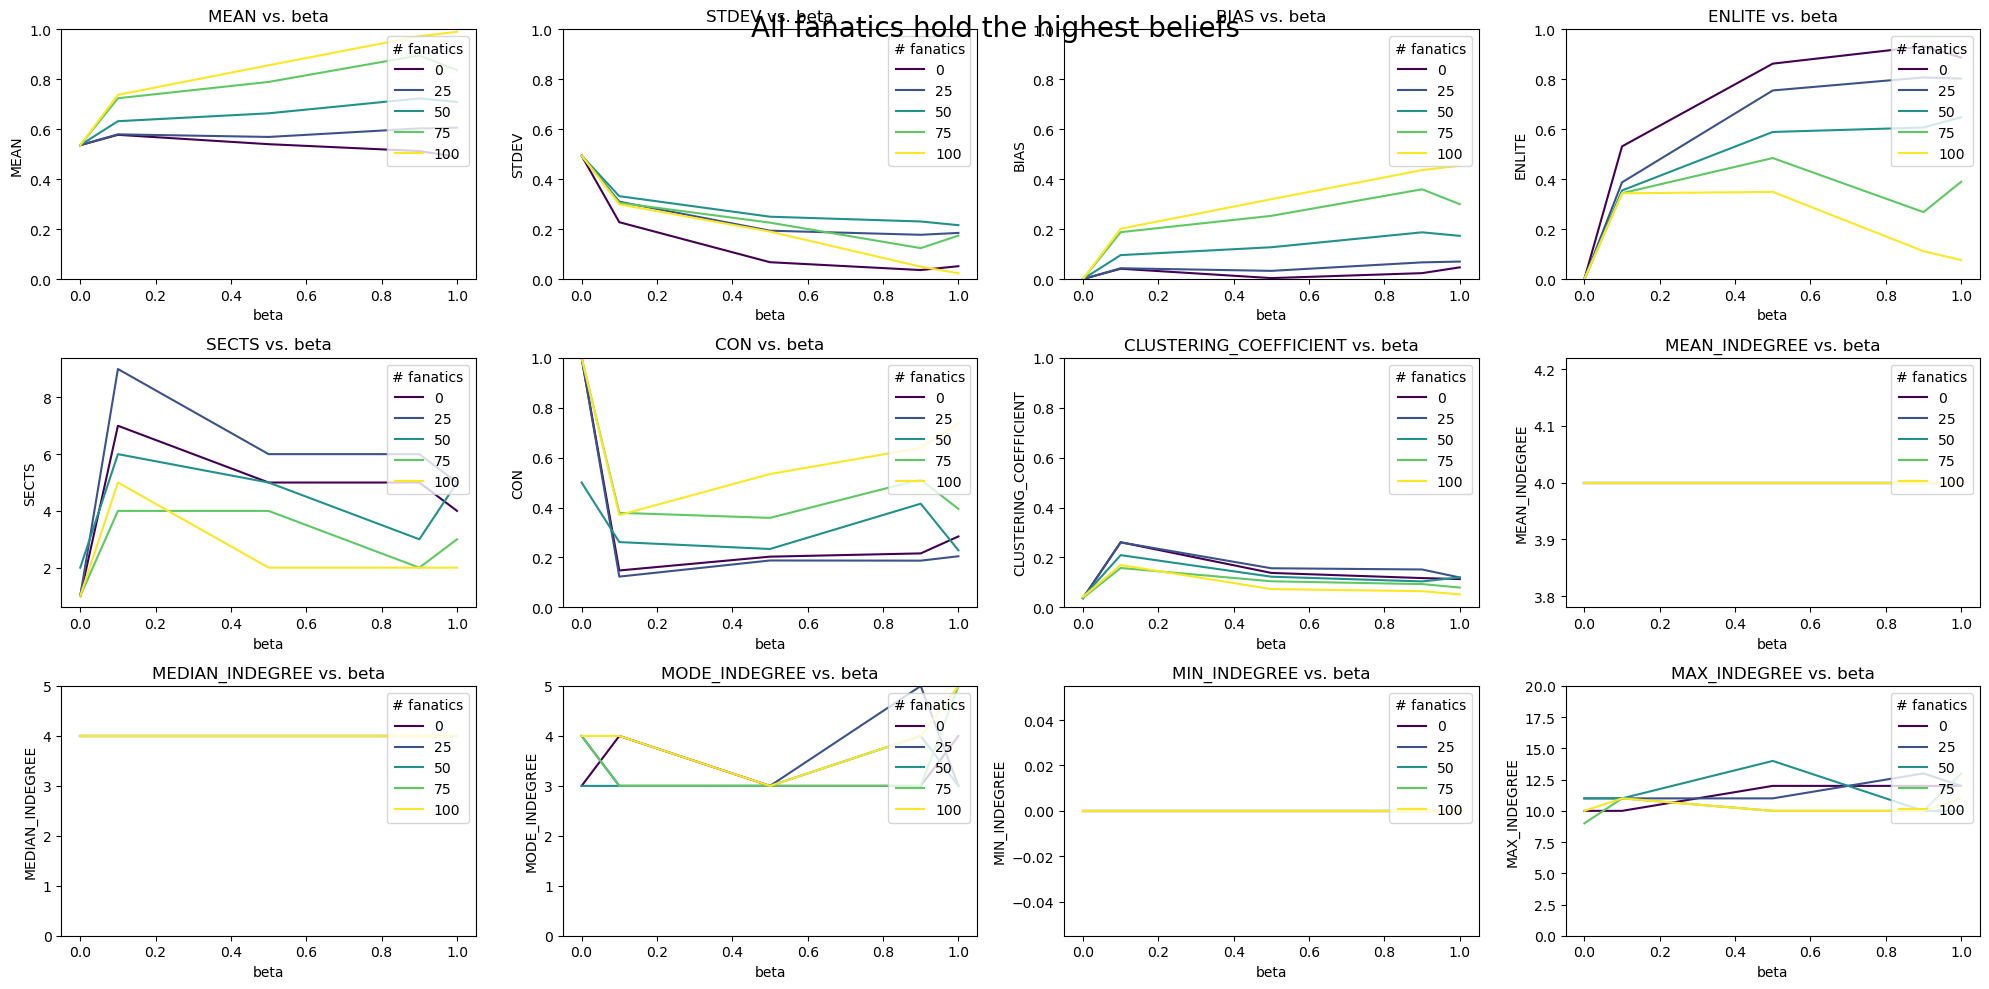

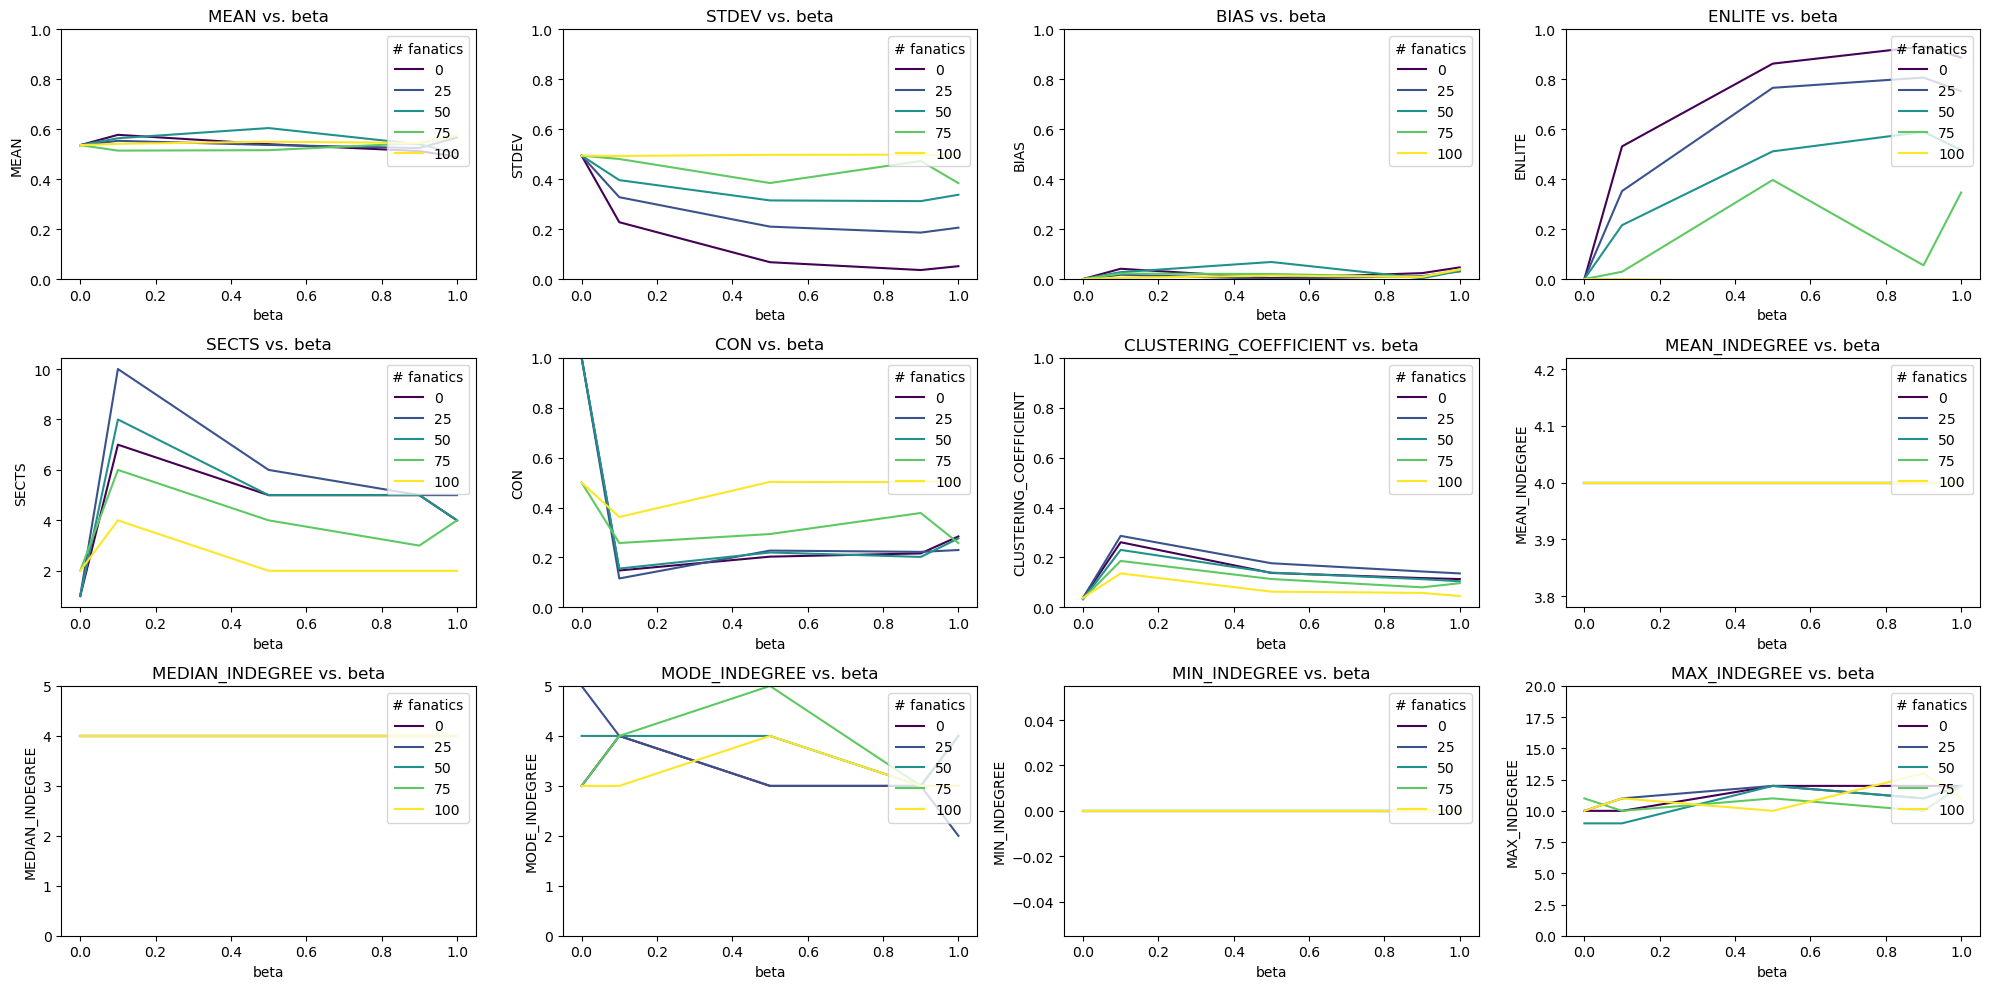

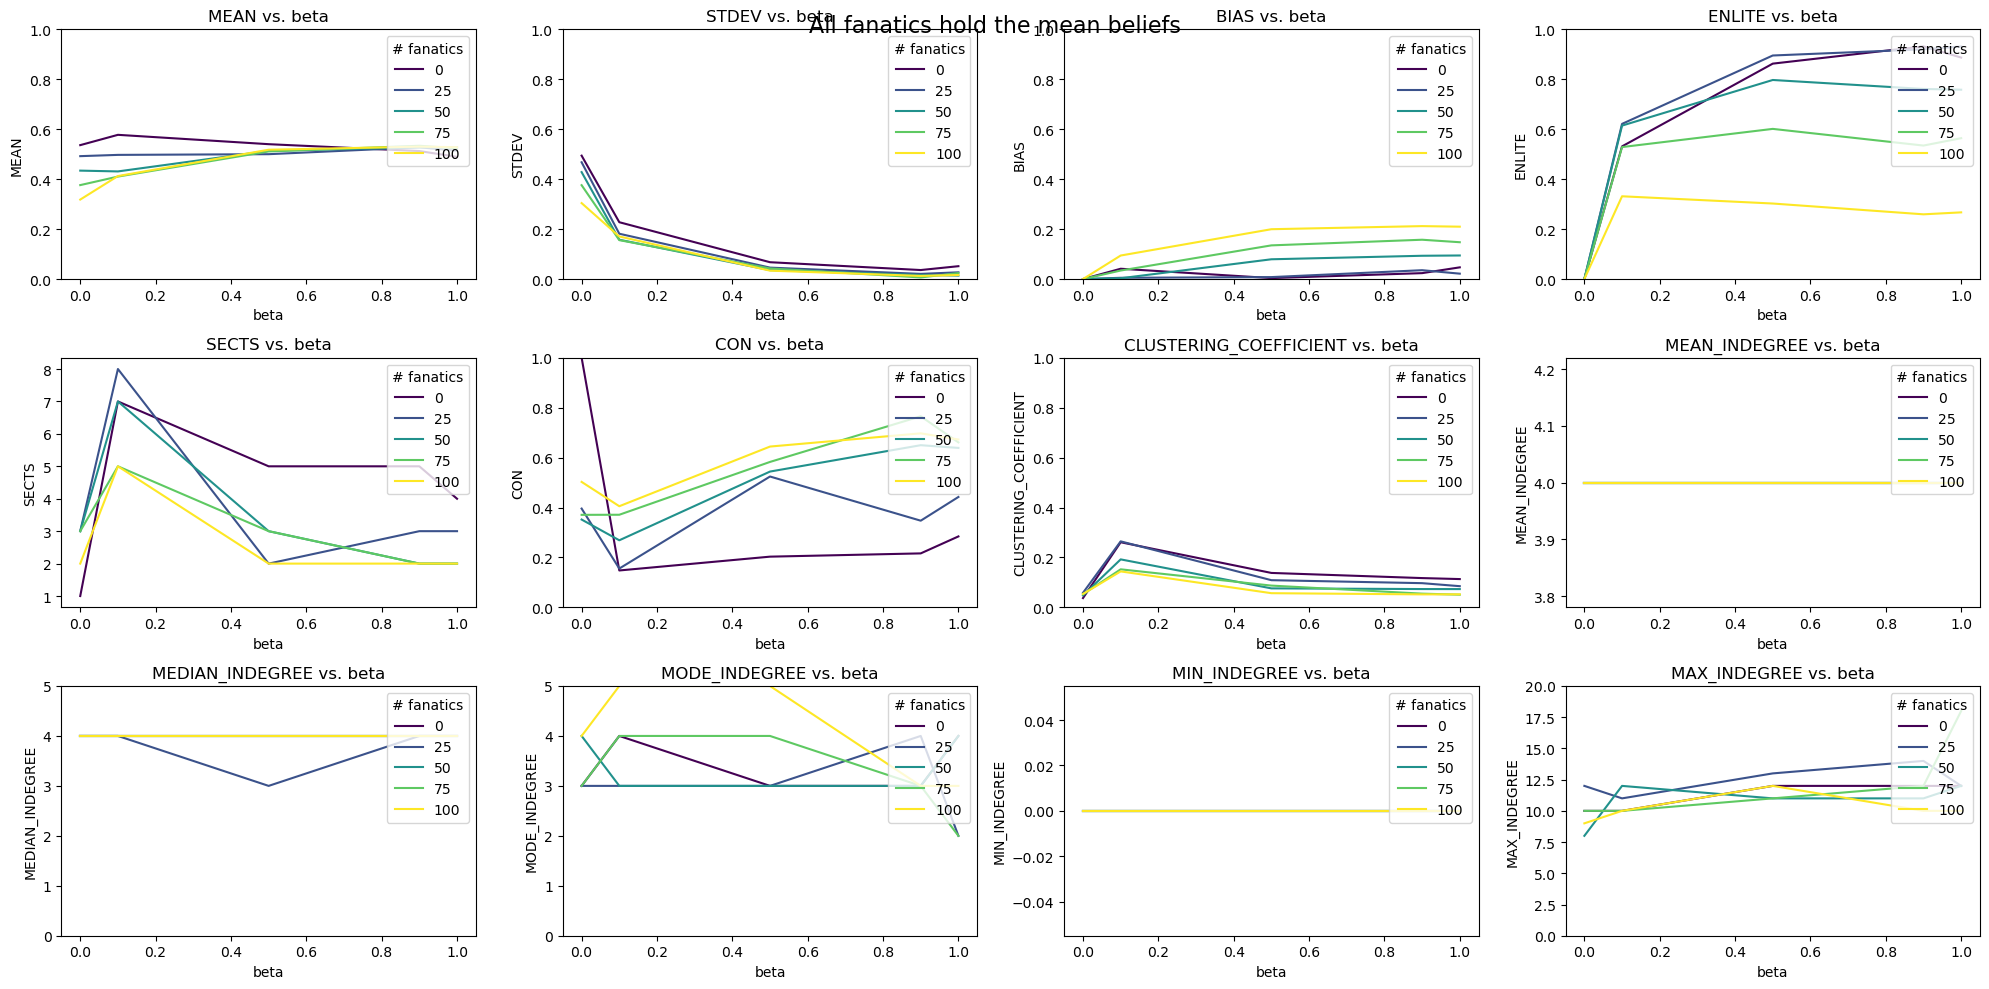

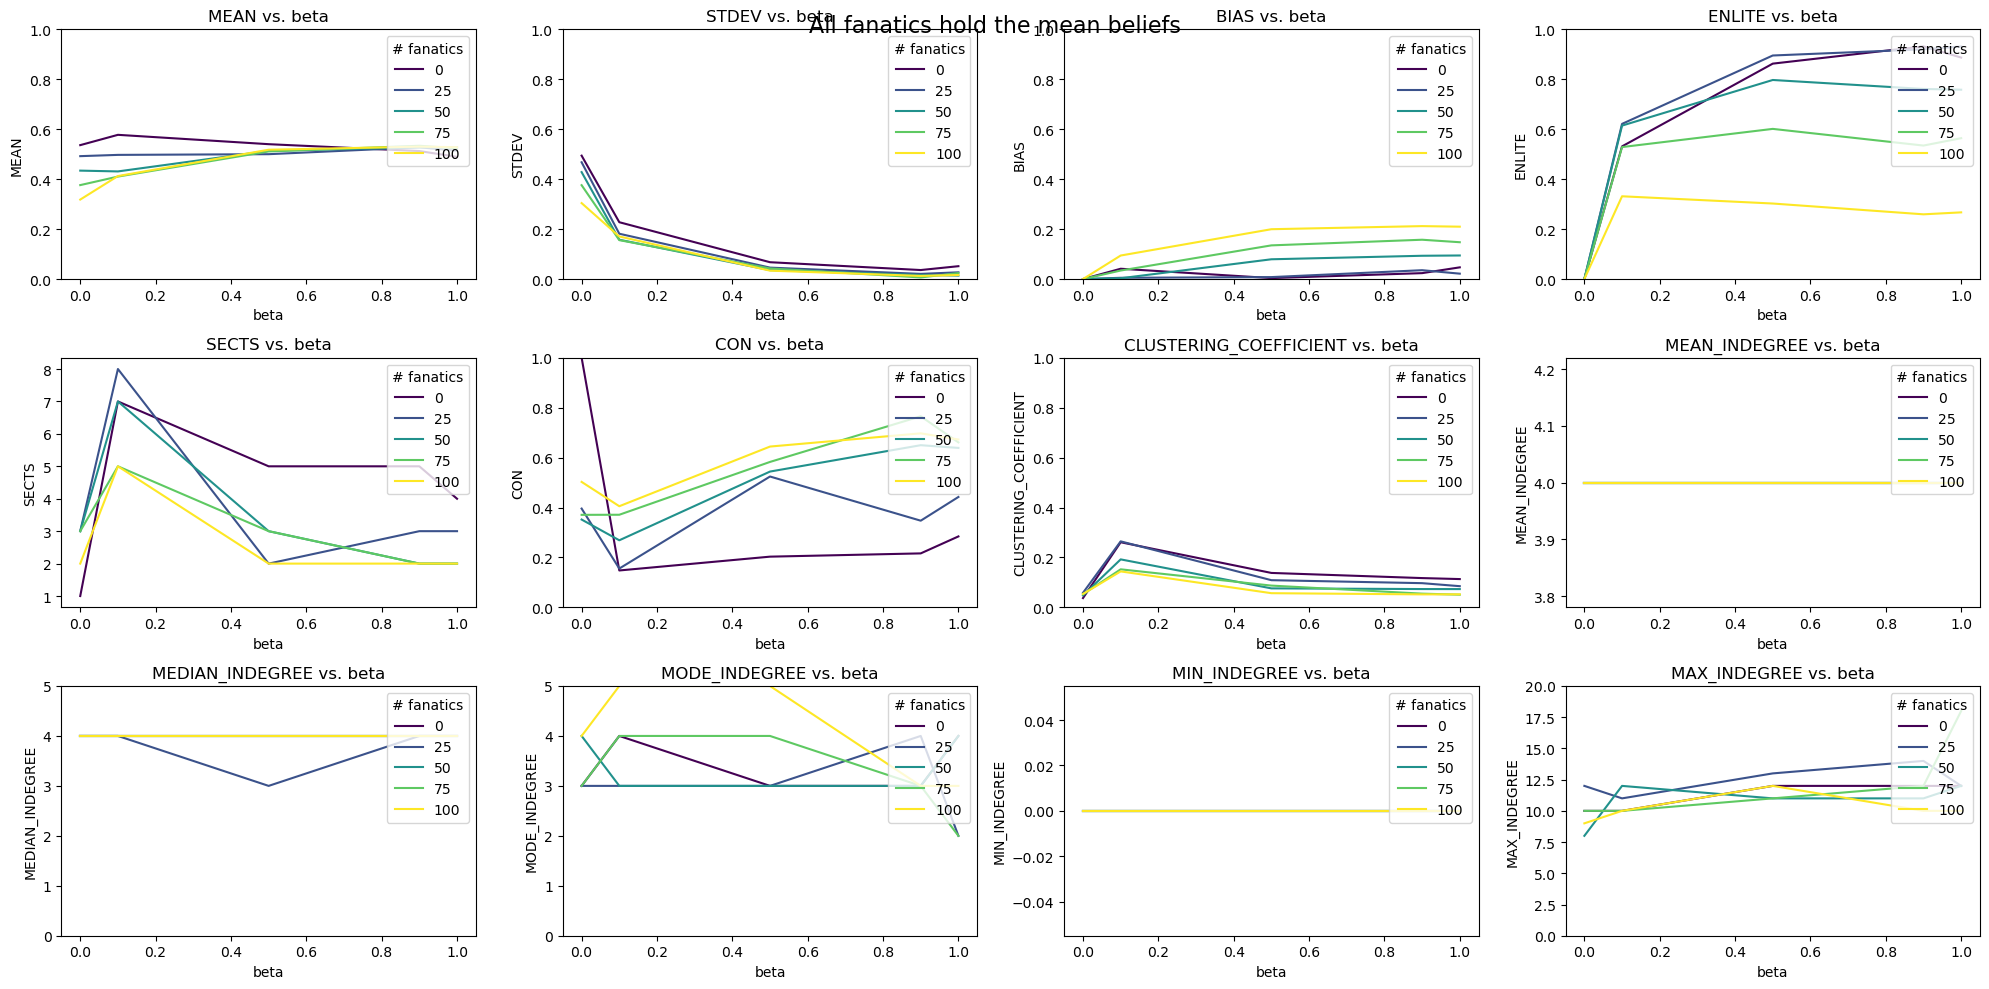

In [19]:
metrics= ['MEAN', 'STDEV', 'BIAS', 'ENLITE', 'SECTS', 'CON', 'CLUSTERING_COEFFICIENT', 'MEAN_INDEGREE','MEDIAN_INDEGREE', 'MODE_INDEGREE', 'MIN_INDEGREE', 'MAX_INDEGREE']

line_plot(data=fanatics_max_high, metrics=metrics, export=True)
line_plot(data=fanatics_min_max_high, metrics=metrics, export=True)
line_plot(data=fanatics_mean_high, metrics=metrics, export=True)

## Animation

### Network

In [16]:
def toimg(fig):
    fig.canvas.draw()
    img = np.array(fig.canvas.renderer.buffer_rgba())
    return cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

def visualize_graph_helper(network: np.ndarray, beliefs: np.ndarray, ax: plt.Axes) -> plt.figure:
    """ Visualize the graphical network of people using library networkx. 
    People within the same of range of beliefs are colored the same.

    Calculate the mean belief of clusters of people within the same range of beliefs and annotate it on the graph.

    Params:
        network (np.ndarray): The network of people
        beliefs (np.ndarray): The beliefs of each person in the network
        conv (int): The current period of the simulation
        export (bool): Export this figure if `true`
        name (str): the OUTPUT_NAME of this program

    Returns:
        fig: a figure of the network of people
    """
    G = nx.from_numpy_array(network, create_using=nx.DiGraph)
    pos = nx.spring_layout(G, seed = 42)
    fig = nx.draw(G, pos, node_size=100, node_color=beliefs, vmin=0, vmax=1,
            cmap=plt.cm.Reds, edge_color='gray', ax=ax)
    # nx.draw_networkx_labels(G, pos, font_size=8, ax=ax)

    plt.close()
    return fig

def visualize_graph(network: np.ndarray, beliefs: np.ndarray, timestep: int,
                    f: str, s: str, b: str, export=False) -> plt.figure:
    fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(15, 15),
                                gridspec_kw={'height_ratios': [1, 3]})
    plt.suptitle(f"Network of {f} {s} fanatics and beta {b} \n at converged step")
    visualize_beliefs_helper(beliefs[timestep], axs[0])
    visualize_graph_helper(network[timestep], beliefs[timestep], axs[1])
    fig.tight_layout()

    # Export
    if export:
        try:
            os.mkdir(f'./plots/{date}')
        except FileExistsError:
            pass
        fig.savefig(f'plots/{date}/{date_time}_network_{f}_{s}_{b}.png')
    return fig

def animate_network(data: pd.DataFrame, beta: float, num_fanatics: int):
    net_arr = data[(data['beta'] == beta) & (data['num_fanatics'] == num_fanatics)]['network_array'].reset_index(drop=True)[0]
    b_arr = data[(data['beta'] == beta) & (data['num_fanatics'] == num_fanatics)]['belief_array'].reset_index(drop=True)[0]
    fanatics_scheme = data["fanatics_scheme"].sample().str.cat(sep='')
    img_arr = []

    for i in range(len(net_arr)):
        fig = visualize_graph(net_arr, b_arr, i, num_fanatics, fanatics_scheme, beta)
        img_arr.append(toimg(fig))
    
    height, width, _ = img_arr[-1].shape
    size = (width, height)
    out = cv2.VideoWriter(f'./plots/{date}/{date_time}_network_{num_fanatics}_{fanatics_scheme}_{beta}.avi',
                          cv2.VideoWriter_fourcc(*'DIVX'), 3, size)
    for i in range(len(img_arr)):
        out.write(img_arr[i])
    out.release()

In [17]:
# Visualize graphs
for s in [fanatics_max_low, fanatics_max_high, fanatics_mean_low, fanatics_mean_high, fanatics_min_max_low, fanatics_min_max_high]:
  for b in [0.1, 0.5, 1.0]:
    for f in [20, 25, 30, 40, 50, 60, 75, 80, 90, 100]:
      network = s[(s['beta'] == b) & (s['num_fanatics'] == f)]['network_array'].reset_index(drop=True)[0]
      belief = s[(s['beta'] == b) & (s['num_fanatics'] == f)]['belief_array'].reset_index(drop=True)[0]
      scheme = s["fanatics_scheme"].sample().str.cat(sep='')
      visualize_graph(network, belief, -1, f, scheme, b, export=True)

KeyError: 0

In [ ]:
# Animate graphs
animate_network(fanatics_max_high, 1.0, 60)